In [7]:
# Install TensorFlow Decision Forests.
!pip3 install tensorflow_decision_forests --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 46.2 MB/s eta 0:00:00


In [9]:
import pandas as pd
import numpy as np
import tensorflow as tf

from tensorflow import keras
import tensorflow_hub as hub
from keras import layers
import tensorflow_decision_forests as tfdf
import matplotlib.pyplot as plt



In [10]:

# Turn .csv files into pandas DataFrame's
df = pd.read_csv(
    "https://raw.githubusercontent.com/IMvision12/Tweets-Classification-NLP/main/train.csv"
)
print(df.head())

df_shuffled = df.sample(frac=1, random_state=42)


   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  


In [11]:
# Dropping id, keyword and location columns as these columns consists of mostly nan values
# we will be using only text and target columns
df_shuffled.drop(["id", "keyword", "location"], axis=1, inplace=True)
df_shuffled.reset_index(inplace=True, drop=True)
print(df_shuffled.head())

test_df = df_shuffled.sample(frac=0.1, random_state=42)
train_df = df_shuffled.drop(test_df.index)
print(f"Using {len(train_df)} samples for training and {len(test_df)} for validation")

def create_dataset(dataframe):
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["text"].to_numpy(), dataframe["target"].to_numpy())
    )
    dataset = dataset.batch(100)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

train_ds = create_dataset(train_df)
test_ds = create_dataset(test_df)

sentence_encoder_layer = hub.KerasLayer(
    "https://tfhub.dev/google/universal-sentence-encoder/4"
)


                                                text  target
0  So you have a new weapon that can cause un-ima...       1
1  The f$&amp;@ing things I do for #GISHWHES Just...       0
2  DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...       1
3  Aftershock back to school kick off was great. ...       0
4  in response to trauma Children of Addicts deve...       0
Using 6852 samples for training and 761 for validation


In [12]:

inputs = layers.Input(shape=(), dtype=tf.string)
outputs = sentence_encoder_layer(inputs)
preprocessor = keras.Model(inputs=inputs, outputs=outputs)
model_1 = tfdf.keras.GradientBoostedTreesModel(preprocessing=preprocessor)
model_2 = tfdf.keras.GradientBoostedTreesModel()



Use /tmp/tmp2xw2uy99 as temporary training directory
Use /tmp/tmpq18_xr75 as temporary training directory


In [13]:
# Compiling model_1
model_1.compile(metrics=["Accuracy", "Recall", "Precision", "AUC"])
# Here we do not specify epochs as, TF-DF trains exactly one epoch of the dataset
model_1.fit(train_ds)


Reading training dataset...
Training dataset read in 0:00:18.561209. Found 6852 examples.
Training model...
Model trained in 0:02:02.417718
Compiling model...
Model compiled.


In [14]:

# Compiling model_2
model_2.compile(metrics=["Accuracy", "Recall", "Precision", "AUC"])
# Here we do not specify epochs as, TF-DF trains exactly one epoch of the dataset
model_2.fit(train_ds)


Reading training dataset...
Training dataset read in 0:00:00.182039. Found 6852 examples.
Training model...
Model trained in 0:00:00.201513
Compiling model...
Model compiled.


In [15]:
logs_1 = model_1.make_inspector().training_logs()
logs_2 = model_2.make_inspector().training_logs()


In [16]:

print("model_1 summary: ")
print(model_1.summary())
print()
print("model_2 summary: ")
print(model_2.summary())


model_1 summary: 
Model: "gradient_boosted_trees_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 512)               256797824 
                                                                 
Total params: 256797825 (979.61 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 256797825 (979.61 MB)
_________________________________________________________________
Type: "GRADIENT_BOOSTED_TREES"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (512):
	model/keras_layer/StatefulPartitionedCall:0.0
	model/keras_layer/StatefulPartitionedCall:0.1
	model/keras_layer/StatefulPartitionedCall:0.10
	model/keras_layer/StatefulPartitionedCall:0.100
	model/keras_layer/StatefulPartitionedCall:0.101
	model/keras_layer/StatefulPartitionedCall:0.102
	model/keras_layer/StatefulPartitionedCall:0.103
	model/keras_layer/StatefulPartitionedCall:0.104
	model/keras_layer/Stat

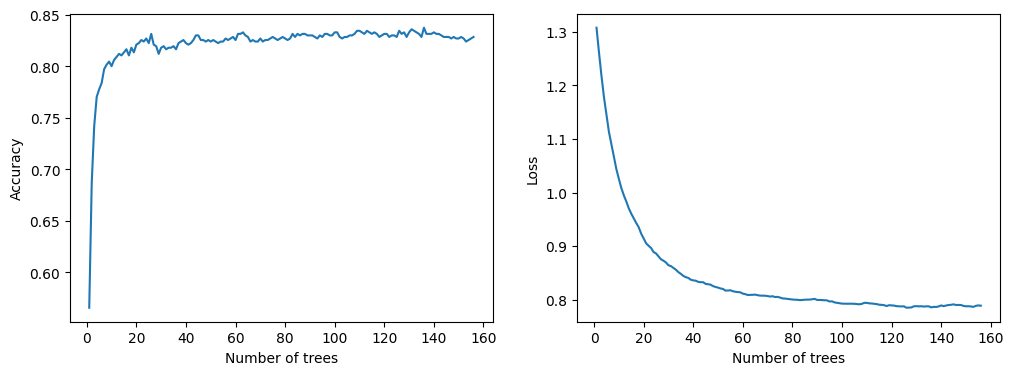

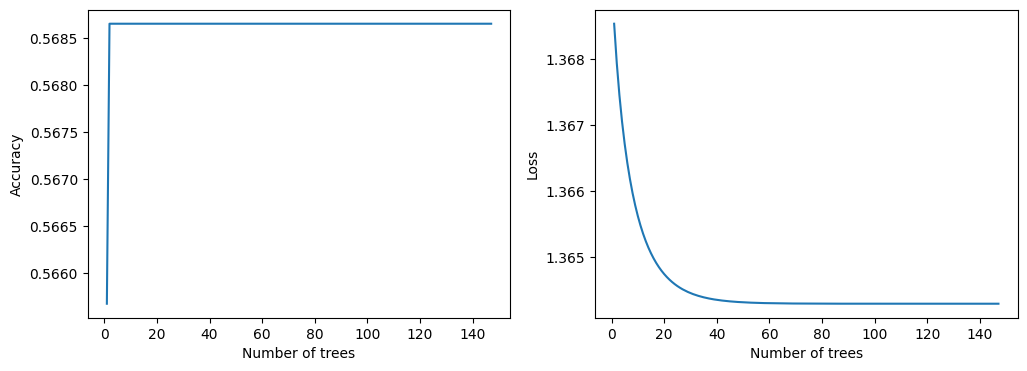

In [17]:

def plot_curve(logs):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
    plt.xlabel("Number of trees")
    plt.ylabel("Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
    plt.xlabel("Number of trees")
    plt.ylabel("Loss")

    plt.show()

plot_curve(logs_1)
plot_curve(logs_2)


In [18]:

results = model_1.evaluate(test_ds, return_dict=True, verbose=0)
print("model_1 Evaluation: \n")
for name, value in results.items():
    print(f"{name}: {value:.4f}")



model_1 Evaluation: 

loss: 0.0000
Accuracy: 0.8055
recall: 0.7126
precision: 0.8378
auc: 0.8668


In [19]:
results = model_2.evaluate(test_ds, return_dict=True, verbose=0)
print("model_2 Evaluation: \n")
for name, value in results.items():
    print(f"{name}: {value:.4f}")



model_2 Evaluation: 

loss: 0.0000
Accuracy: 0.5440
recall: 0.0029
precision: 1.0000
auc: 0.5026


In [20]:
test_df.reset_index(inplace=True, drop=True)
for index, row in test_df.iterrows():
    text = tf.expand_dims(row["text"], axis=0)
    preds = model_1.predict_step(text)
    preds = tf.squeeze(tf.round(preds))
    print(f"Text: {row['text']}")
    print(f"Prediction: {int(preds)}")
    print(f"Ground Truth : {row['target']}")
    if index == 10:
        break

Text: DFR EP016 Monthly Meltdown - On Dnbheaven 2015.08.06 http://t.co/EjKRf8N8A8 #Drum and Bass #heavy #nasty http://t.co/SPHWE6wFI5
Prediction: 0
Ground Truth : 0
Text: FedEx no longer to transport bioterror germs in wake of anthrax lab mishaps http://t.co/qZQc8WWwcN via @usatoday
Prediction: 1
Ground Truth : 0
Text: Gunmen kill four in El Salvador bus attack: Suspected Salvadoran gang members killed four people and wounded s... http://t.co/CNtwB6ScZj
Prediction: 1
Ground Truth : 1
Text: @camilacabello97 Internally and externally screaming
Prediction: 0
Ground Truth : 1
Text: Radiation emergency #preparedness starts with knowing to: get inside stay inside and stay tuned http://t.co/RFFPqBAz2F via @CDCgov
Prediction: 1
Ground Truth : 1
Text: Investigators rule catastrophic structural failure resulted in 2014 Virg.. Related Articles: http://t.co/Cy1LFeNyV8
Prediction: 1
Ground Truth : 1
Text: How the West was burned: Thousands of wildfires ablaze in #California alone http://t.co/iCSjGZ